# Experiment 1: preemption cost caracterization for Spark on Hadoop


## Overview

### Objectives

This experiment aims at showing the mechanism used by Spark over Yarn to manage resource preemption in order to deduce the cost of resource preemption.

We need to understand the way Hadoop Yarn is managing the resource decommission en recommision, and the way Spark reschedule the remaining jobs in different conditions:

- With or without running Spark jobs on the resource
- With different type of Spark application (different task size)
- With different number of preemption

Also, we want to know the quantity of work that needs to be recompute at every preemption events regarding the stage the job is on and the level of completion.

### Results expectation

We think that resource preemption that reduce Spark jobs executor number can is manage by Spark like this:

1. Yarn inform Spark that it will remove node
2. Spark finish (or kill?) the tasks and give the resource back to Yarn 
3. Yarn actually remove the resources from his pool and stop the node manager.

The cost of the preemption (in time to compute the same task) should be correlated to the amount of work that has to be recompute. This amount can be quantify by the makespan time difference between running the Spark app alone and with preemption. This time can be compute under different conditions describe in the experiment variables section.

Test with Flink is also needed to be sure that streaming is not able to manage this type of preemption.


### Experiment parameters

Fixed parameters:

- Number of running application is fixed to 1
- Number of node available fixed to 8
- number of Yarn containers (equals number of nodes)
- Type of framework fixed to Spark (can be extended to flink later)
- Fix preemption pattern to one preemption only with no resource return

These are the experiments parameters that we will varies

- Type of the application:
    - Grep
    - WordCount
    - K-Mean

- Input size of the application
    - 32Gb
    - 128Gb
    - 512Gb

- Preemption scheme with no resource return
    - ratio (in % of the app resources):
        - 25%
        - 50%
        - 75%
        - 100%
    - one preemption event at different level of the application completion
        - 1%
        - 25%
        - 50%
        - 75%
        - 99%

    

### Expected outputs

That metrics should be returned by the experiment script:

- Makespan of the Spark job
- Timestamp and size of each preemptions

It should return all the data necessary to compute a dataframe that looks like the following:


## Setup

We use the Grisou cluster in Nancy's Grid5000 site. We have configured Yarn to use 1 executor per node, but it leave 1 core and 8G of memory for the system. Hence the following possible configurations:

In [2]:
from pprint import pprint
config = []
for nb_node in [2, 4, 8, 16, 32]: 
    config.append({"nb_node": nb_node, "request":{'mem': 120 * nb_node, 'cpu': 15 * nb_node}})
pprint(config) 

[{'nb_node': 2, 'request': {'cpu': 30, 'mem': 240}},
 {'nb_node': 4, 'request': {'cpu': 60, 'mem': 480}},
 {'nb_node': 8, 'request': {'cpu': 120, 'mem': 960}},
 {'nb_node': 16, 'request': {'cpu': 240, 'mem': 1920}},
 {'nb_node': 32, 'request': {'cpu': 480, 'mem': 3840}}]


Yarn is configured with 1 container per node.

Spark is configured to use dynamic resource request.

First, let's do a simple implementation on a small sub part of the parameters.

In [3]:
!cat minimal_parameters.json

{
    "description": "Preemption cost charaterisation",
    "grid5000_site": "Nancy",
    "resources": "{cluster='grisou'}/nodes=9",
    "walltime": "02:45:00",
    "kadeploy_master_env": "bebida-master",
    "kadeploy_slave_env": "bebida-slave",
    "parameters": {
        "framework_type": ["Spark"],
        "applications_type": ["Grep"],
        "data_size": [32],
        "preemption": {
          "none": {},
          "once":{
            "ratio": [0.5],
            "event_completion_ratio": [0.1, 0.25, 0.50, 0.75, 0.99]
          }
        }
    }
}


# Results analysis

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
df = DataFrame.from_csv("~/scratch/results_2017-03-03--17-30-33/results.csv")

# Filter failed experiments
print("Number of failed experiments: {}".format(len(df[df["exit_code"] != 0])))
df = df[df["exit_code"] == 0]

# Fill control experiment NaN field
df["preempt_resource_ratio"] = df["preempt_resource_ratio"].fillna(0)
df["preempt_time_ratio"] = df["preempt_time_ratio"].fillna(0)

df

Number of failed experiments: 0


app_id application_name application_parameters  \
1   application_1488564860992_0001             Grep    word Grep-1-result1   
2   application_1488564860992_0002             Grep    word Grep-2-result2   
3   application_1488564860992_0003             Grep    word Grep-3-result3   
4   application_1488564860992_0004             Grep    word Grep-1-result4   
5   application_1488564860992_0005             Grep    word Grep-2-result5   
6   application_1488564860992_0006             Grep    word Grep-3-result6   
7   application_1488564860992_0007             Grep    word Grep-1-result7   
8   application_1488564860992_0008             Grep    word Grep-2-result8   
9   application_1488564860992_0009             Grep    word Grep-3-result9   
10  application_1488564860992_0010           KMeans                    3 3   
11  application_1488564860992_0011           KMeans                    3 3   
12  application_1488564860992_0012           KMeans                    3 3   
13  application_1488564860992_0013           KMeans                    3 3   
14  application_1488564860992_0014           KMeans                    3 3   
15  application_1488564860992_0015           KMeans                    3 3   
16  application_1488564860992_0016           KMeans                    3 3   
17  application_1488564860992_0017           KMeans                    3 3   
18  application_1488564860992_0018           KMeans                    3 3   
19  application_1488564860992_0019        WordCount   WordCount-1-result19   
20  application_1488564860992_0020        WordCount   WordCount-2-result20   
21  application_1488564860992_0021        WordCount   WordCount-3-result21   
22  application_1488564860992_0022        WordCount   WordCount-1-result22   
23  application_1488564860992_0023        WordCount   WordCount-2-result23   
24  application_1488564860992_0024        WordCount   WordCount-3-result24   
25  application_1488564860992_0025        WordCount   WordCount-1-result25   
26  application_1488564860992_0026        WordCount   WordCount-2-result26   
27  application_1488564860992_0027        WordCount   WordCount-3-result27   
28  application_1488564860992_0028             Grep   word Grep-1-result28   
29  application_1488564860992_0029             Grep   word Grep-1-result29   
30  application_1488564860992_0030             Grep   word Grep-1-result30   
31  application_1488564860992_0031             Grep   word Grep-1-result31   
32  application_1488564860992_0032             Grep   word Grep-1-result32   
33  application_1488564860992_0033             Grep   word Grep-1-result33   
34  application_1488564860992_0034             Grep   word Grep-1-result34   
35  application_1488564860992_0035             Grep   word Grep-1-result35   
36  application_1488564860992_0036             Grep   word Grep-1-result36   
37  application_1488564860992_0037             Grep   word Grep-1-result37   
38  application_1488564860992_0038             Grep   word Grep-1-result38   
39  application_1488564860992_0039             Grep   word Grep-1-result39   
40  application_1488564860992_0040             Grep   word Grep-1-result40   
41  application_1488564860992_0041             Grep   word Grep-1-result41   
42  application_1488564860992_0042             Grep   word Grep-1-result42   
43  application_1488564860992_0043             Grep   word Grep-1-result43   
44  application_1488564860992_0044             Grep   word Grep-1-result44   
45  application_1488564860992_0045             Grep   word Grep-1-result45   
46  application_1488564860992_0046             Grep   word Grep-1-result46   
47  application_1488564860992_0047             Grep   word Grep-1-result47   
48  application_1488564860992_0048             Grep   word Grep-1-result48   
49  application_1488564860992_0049             Grep   word Grep-1-result49   
50  application_1488564860992_0050             Grep   word Grep-1-result50   
51  application_1488564860992_0051             Gre

Look at the control experiments:


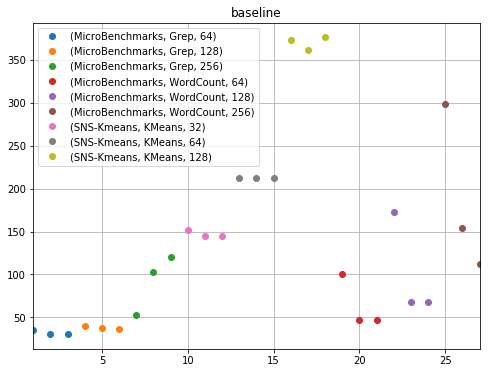

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
for label, sub_df in df[df["preempt_resource_ratio"] == 0].groupby(['application_type', 'application_name', "data_size"]):
        # compute preemption cost
        sub_df.plot(y="execution_time", style='o', ax=ax, label=label, title="baseline")
plt.grid()
plt.legend()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


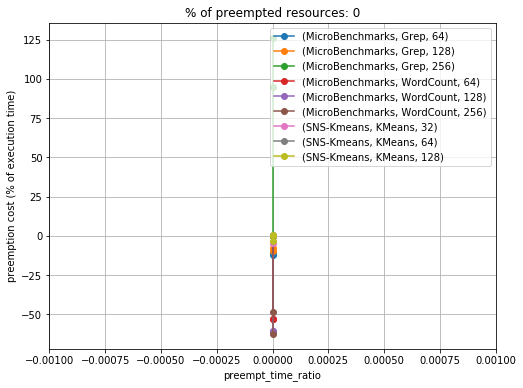

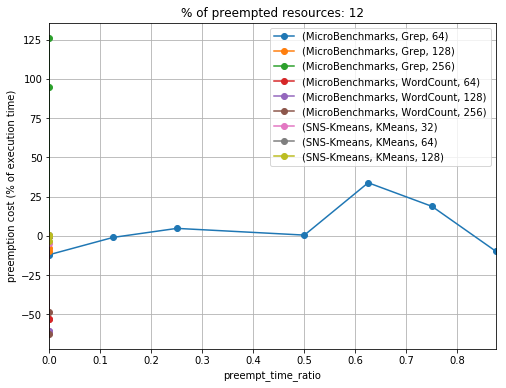

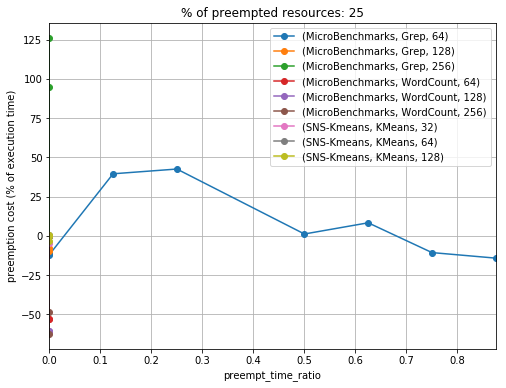

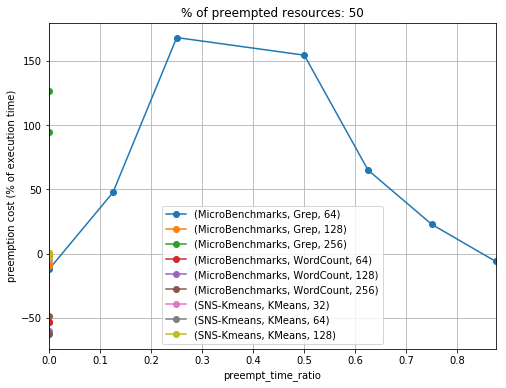

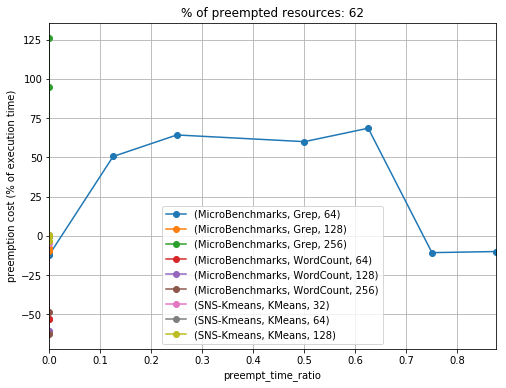

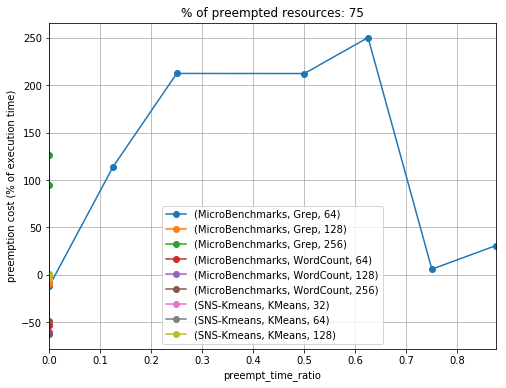

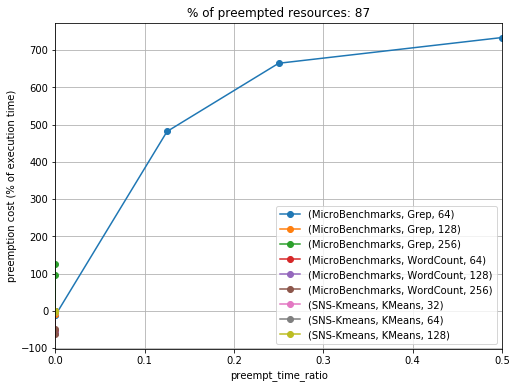

In [28]:
for ratio in df["preempt_resource_ratio"].unique():
    fig, ax = plt.subplots(figsize=(8,6))
    for label, sub_df in df[((df["preempt_resource_ratio"] == ratio) | (df["preempt_resource_ratio"] == 0))].groupby(['application_type', 'application_name', "data_size"]):
        # compute preemption cost
        baseline = sub_df[(df["preempt_resource_ratio"] == 0)]["execution_time"].iloc[0]
        sub_df["preemption_cost"] = ((sub_df["execution_time"] - baseline) / baseline) * 100
        sub_df.plot(x="preempt_time_ratio", y="preemption_cost", style='o-', ax=ax, label=label, title="% of preempted resources: " + str(int(ratio * 100)))
        ax.set_ylabel("preemption cost (% of execution time)")
    plt.grid()
    plt.legend()


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


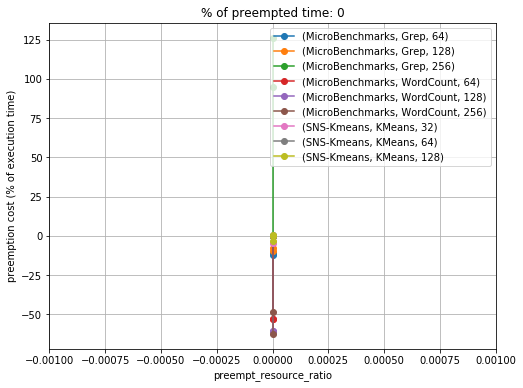

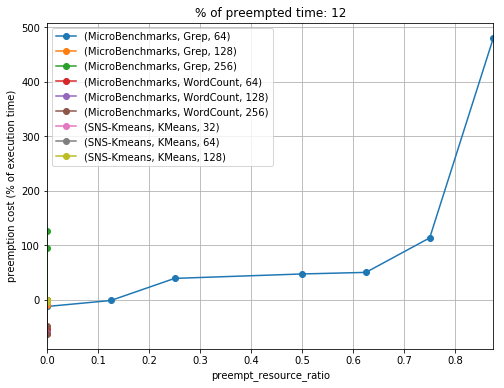

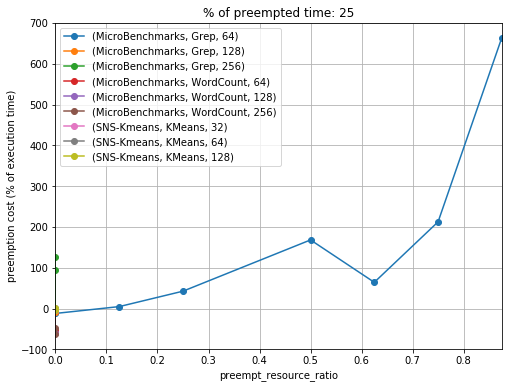

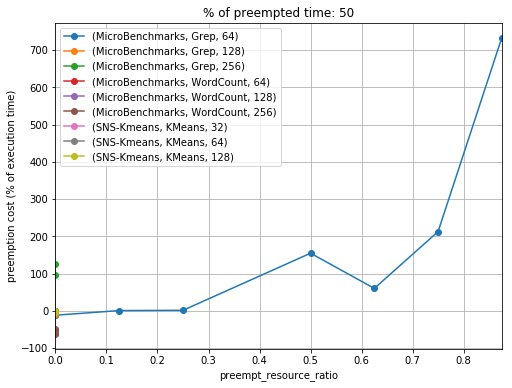

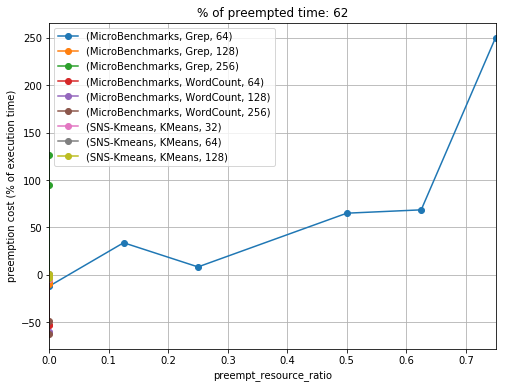

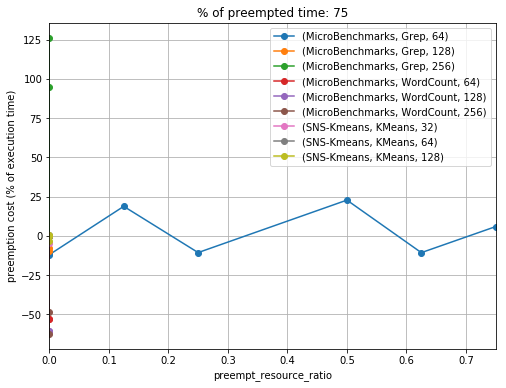

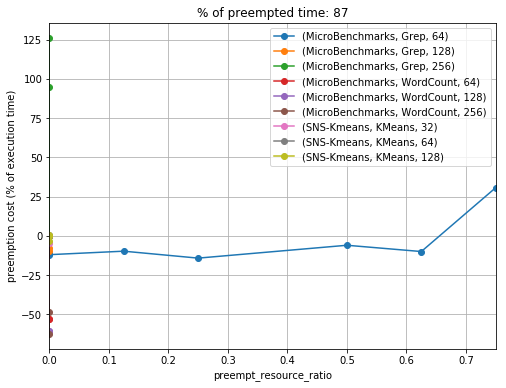

In [29]:
for ratio in df["preempt_time_ratio"].unique():
    fig, ax = plt.subplots(figsize=(8,6))
    for label, sub_df in df[((df["preempt_time_ratio"] == ratio) | (df["preempt_time_ratio"] == 0))].groupby(['application_type', 'application_name', "data_size"]):
        # compute preemption cost
        baseline = sub_df[(df["preempt_time_ratio"] == 0)]["execution_time"].iloc[0]
        sub_df["preemption_cost"] = ((sub_df["execution_time"] - baseline) / baseline) * 100
        sub_df.plot(x="preempt_resource_ratio", y="preemption_cost", style='o-', ax=ax, label=label, title="% of preempted time: " + str(int(ratio * 100)))
        ax.set_ylabel("preemption cost (% of execution time)")
    plt.grid()
    plt.legend()


Check if there is a corelation between the computation area (time * resources) and execution time.

KeyError: 'nb_executor'

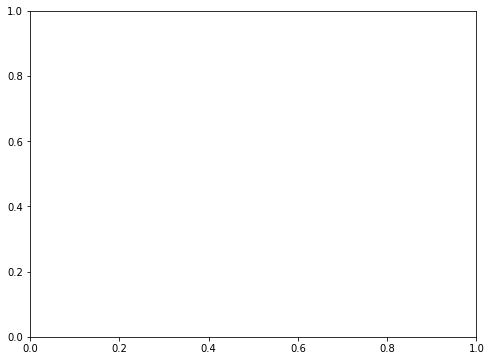

In [37]:

for ratio in df["preempt_resource_ratio"].unique():
    fig, ax = plt.subplots(figsize=(8,6))
    for label, sub_df in df[((df["preempt_resource_ratio"] == ratio) | (df["preempt_resource_ratio"] == 0))].groupby(['application_type', 'application_name', "data_size"]):
        # compute preemption cost
        baseline = sub_df[(sub_df["preempt_resource_ratio"] == 0)]["execution_time"].iloc[0]
        time_before_preemt = baseline * sub_df["preempt_time_ratio"]
        time_after_preempt = sub_df["execution_time"] - time_before_preemt
        sub_df["computation_area"] = (
            sub_df["nb_executor"] * time_before_preemt) + (
            sub_df["nb_executor"] * time_after_preempt)
        sub_df["preemption_cost"] = ((sub_df["execution_time"] - baseline) / baseline) * 100
        sub_df.plot(x="computation_area", y="preemption_cost", style='o-', ax=ax, label=label, title="% of preempted resources: " + str(int(ratio * 100)))
        ax.set_ylabel("preemption cost (% of execution time)")
    plt.grid()
    plt.legend()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


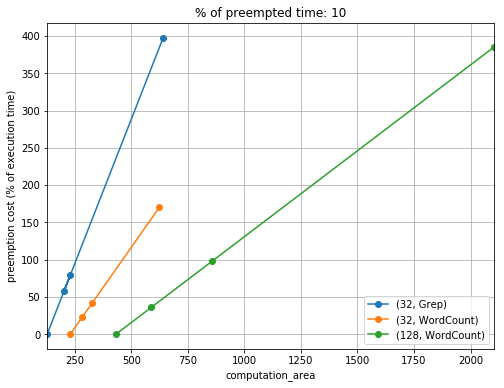

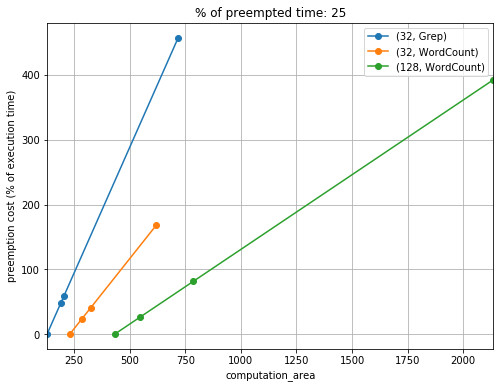

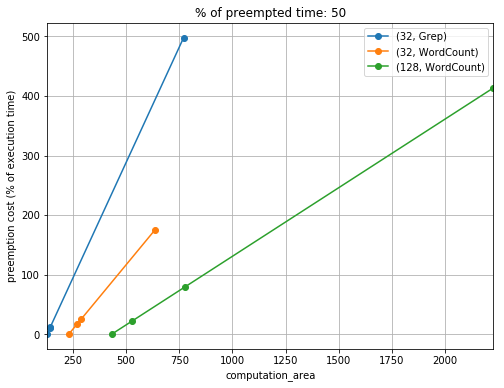

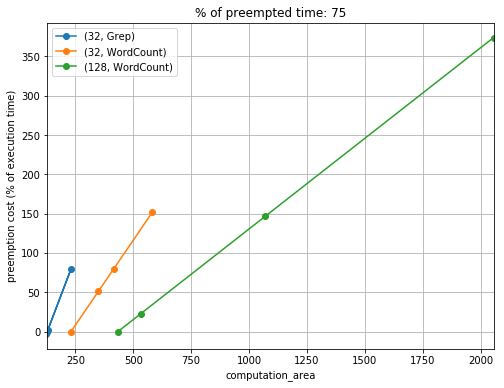

In [147]:

for ratio in [0.10, 0.25, 0.5, 0.75]:
    fig, ax = plt.subplots(figsize=(8,6))
    for label, sub_df in df[((df["event_completion_ratio"] == ratio) | (df["event_completion_ratio"] == 0))].groupby(["data_size", 'application_type']):
        # compute preemption cost
        baseline = sub_df[(sub_df["event_completion_ratio"] == 0)]["execution_time"].iloc[0]
        time_before_preemt = baseline * sub_df["event_completion_ratio"]
        time_after_preempt = sub_df["execution_time"] - time_before_preemt
        sub_df["computation_area"] = (
            sub_df["nb_executor"] * time_before_preemt) + (
            sub_df["nb_executor"] * time_after_preempt)
        sub_df["preemption_cost"] = ((sub_df["execution_time"] - baseline) / baseline) * 100
        sub_df.plot(x="computation_area", y="preemption_cost", style='o-', ax=ax, label=label, title="% of preempted time: " + str(int(ratio * 100)))
        ax.set_ylabel("preemption cost (% of execution time)")
    plt.grid()
    plt.legend()
